In [3]:
! pip3 install evaluate
import os
from torch.utils.data import TensorDataset

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Drive already mounted at /content/drive; to attempt to forcibly remount, call driv

In [4]:
%load_ext autoreload
%autoreload

from src.common import get_device, read_data
from src.quantemp_processor import QuantempProcessor, QT_VERACITY_LABELS
from src.models.gpt2 import Gpt2Tokenizer, Gpt2Classifier
from src.classification_training import ClassificationTraining

import torch
import logging
from torch import nn

MODEL = 'gpt2'
DECOMPOSITION = 'gpt3.5-turbo'

# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

logging.basicConfig(level=logging.ERROR)

device = get_device()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA: 1, use NVIDIA A100-SXM4-40GB


In [5]:
train_data = read_data(f'{DECOMPOSITION}/train_evidences_decomposed_{DECOMPOSITION}.json')
val_data = read_data(f'{DECOMPOSITION}/val_evidences_decomposed_{DECOMPOSITION}.json')
test_data = read_data(f'{DECOMPOSITION}/test_evidences_decomposed_{DECOMPOSITION}.json')

limit = 20
train_data = train_data[:limit]
val_data = val_data[:limit]
test_data = test_data[:limit]

In [6]:
%autoreload

tokenizer = Gpt2Tokenizer()
data_processor = QuantempProcessor(tokenizer, decomposition='decomposition')

train_dataset = data_processor.transform(train_data)
val_dataset = data_processor.transform(val_data)
test_dataset = data_processor.transform(test_data)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
%autoreload

model = Gpt2Classifier("gpt2", len(QT_VERACITY_LABELS), mlp_dim=1024, dropout=0.1).to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [8]:
%autoreload

training = ClassificationTraining(
    model_name=f"{MODEL}_{DECOMPOSITION}",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
    loss_function=nn.CrossEntropyLoss(),
    batch_size=16,
    device=device,
    random_state=0
)

In [9]:
%autoreload

training.start_new_training()
# training.resume_training()

Starting new training from epoch 1



EPOCH 1


train:   0%|          | 0/2 [00:00<?, ?it/s]

val:   0%|          | 0/2 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.840 | 59.38
   eval:  0.746 | 87.50
Saved checkpoint: epoch_01
Saved best model: best_model_01


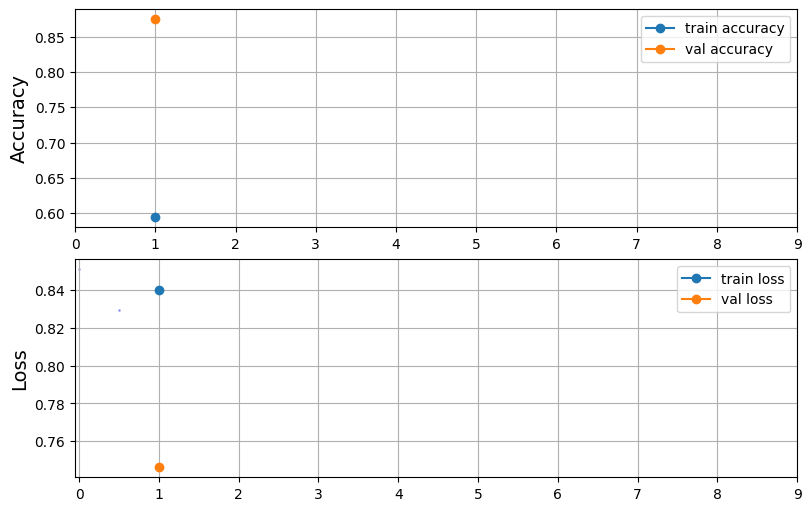


EPOCH 2


train:   0%|          | 0/2 [00:00<?, ?it/s]

val:   0%|          | 0/2 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.859 | 68.75
   eval:  0.779 | 87.50
Saved checkpoint: epoch_02
Removed: epoch_01


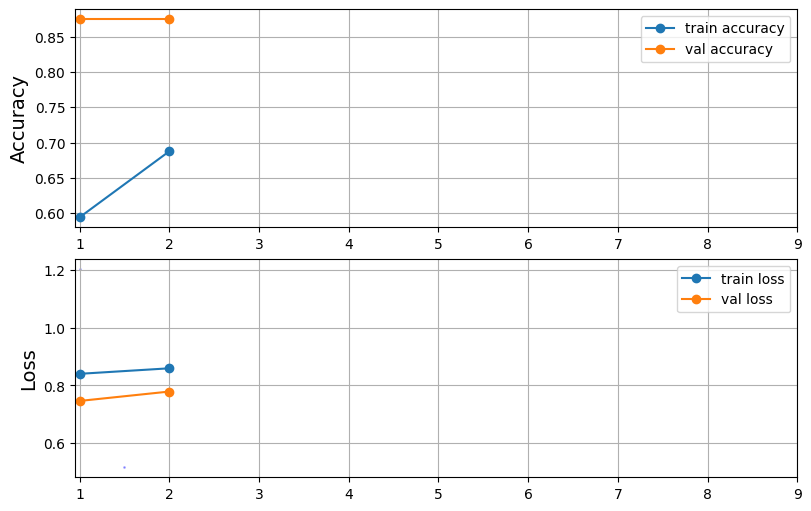


EPOCH 3


train:   0%|          | 0/2 [00:00<?, ?it/s]

val:   0%|          | 0/2 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.816 | 62.50
   eval:  0.756 | 87.50
Saved checkpoint: epoch_03
Removed: epoch_02


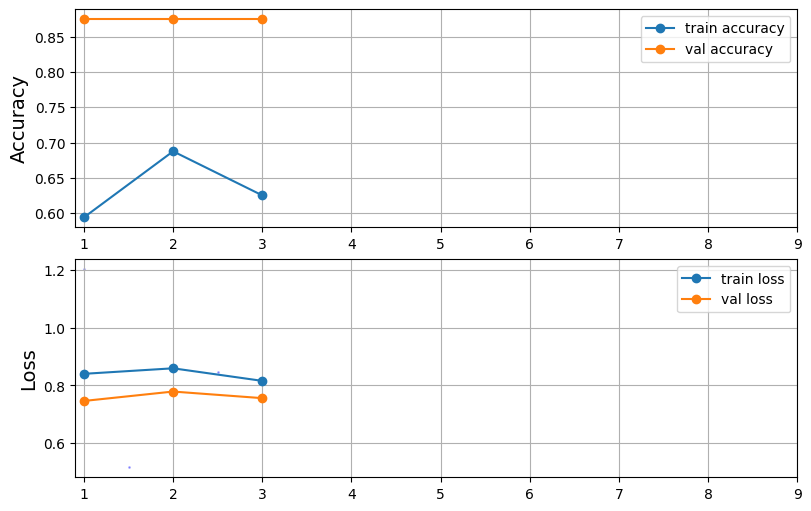


EPOCH 4


train:   0%|          | 0/2 [00:00<?, ?it/s]

val:   0%|          | 0/2 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.803 | 68.75
   eval:  0.743 | 87.50
Saved checkpoint: epoch_04
Removed: epoch_03


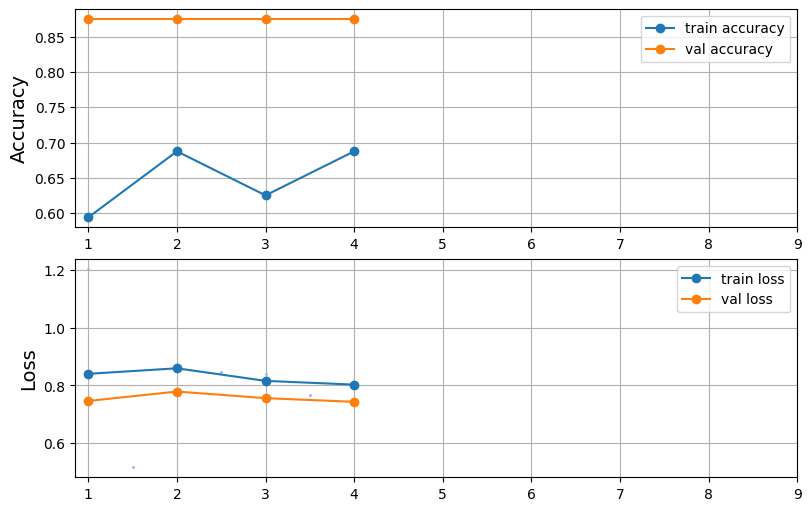


EPOCH 5


train:   0%|          | 0/2 [00:00<?, ?it/s]

val:   0%|          | 0/2 [00:00<?, ?it/s]

          loss  | accuracy
  train:  1.039 | 53.12
   eval:  0.747 | 87.50
Saved checkpoint: epoch_05
Removed: epoch_04


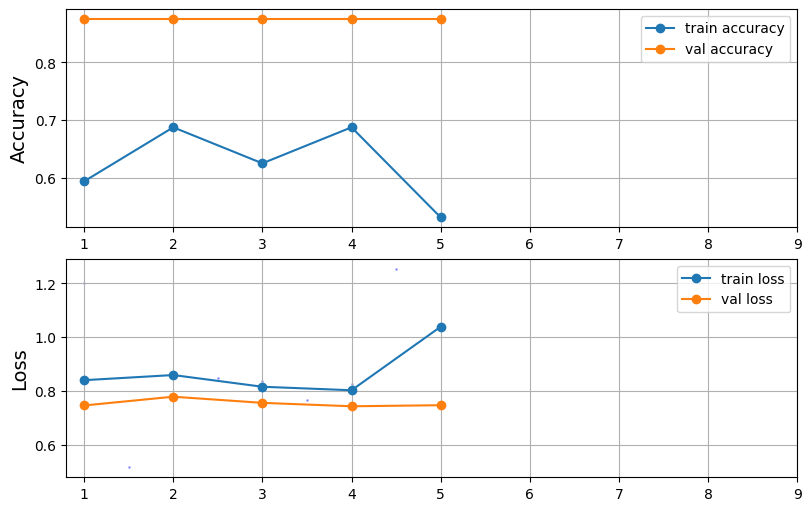

In [10]:
%autoreload
training.train(epochs=5, patience=None)

In [19]:
%autoreload

test_predictions = training.evaluate_best_model(test_data, test_dataset)

Loading model: best_model_01


  0%|          | 0/1 [00:00<?, ?it/s]

Saved to output/gpt2_gpt3.5-turbo.csv.csv/txt
